### Overview<br>

Indentify **top 5** countries that are in the direst **need of aid** by **clustering** them based on **socio-economic** and **health factors**.

Steps involved in Analysis
1. Reading and Understanding Data
2. Exploratory Data Analysis  
  2.1 Null value check  
  2.2 Visualising data
3. Prepare data for Clustering   
   3.1. Outlier Analysis and Treatment
4. Clustering  
  4.1 Hopkins Score  
  4.2 Scaling  
  4.3 Finding the number of cluster  
  4.4 K means clustering   
  4.5 Hierarchical clustering   
5. Recommendation

## Importing required libraries 

In [1]:
# supressing warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# for numeric analysis
import numpy as np

# for dataframe manipulation
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format

# for detecting encoding scheme
import chardet

# for data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

# for analysis
import sklearn

# for scaling 
from sklearn.preprocessing import StandardScaler 

# for analysing hopkins score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from math import isnan
from random import sample
from numpy.random import uniform 

# for analysing silhouette score 
from sklearn.metrics import silhouette_score

# for hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
# identifying encoding scheme 

def encoding(file):
    read = open(file,'rb').read()
    encode = chardet.detect(read).get('encoding')
    return encode 

print('Country Data : ',encoding('Country_Data.csv'))

Country Data :  ascii


## Step 1 : Reading and Understanding data 

In [4]:
# reading Country_data

data = pd.read_csv('Country_Data.csv',encoding='ascii')
data.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200
5,Argentina,14.5000,18.9000,8.1000,16.0000,18700,20.9000,75.8000,2.3700,10300
6,Armenia,18.1000,20.8000,4.4000,45.3000,6700,7.7700,73.3000,1.6900,3220
7,Australia,4.8000,19.8000,8.7300,20.9000,41400,1.1600,82.0000,1.9300,51900
8,Austria,4.3000,51.3000,11.0000,47.8000,43200,0.8730,80.5000,1.4400,46900
9,Azerbaijan,39.2000,54.3000,5.8800,20.7000,16000,13.8000,69.1000,1.9200,5840


In [5]:
# inspecting shape 

data.shape

(167, 10)

In [6]:
# inspecting column data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
# inspecting numerical columns

data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,38.2701,41.1090,6.8157,46.8902,"17,144.6886",7.7818,70.5557,2.9480,"12,964.1557"
std,40.3289,27.4120,2.7468,24.2096,"19,278.0677",10.5707,8.8932,1.5138,"18,328.7048"
min,2.6000,0.1090,1.8100,0.0659,609.0000,-4.2100,32.1000,1.1500,231.0000
25%,8.2500,23.8000,4.9200,30.2000,"3,355.0000",1.8100,65.3000,1.7950,"1,330.0000"
50%,19.3000,35.0000,6.3200,43.3000,"9,960.0000",5.3900,73.1000,2.4100,"4,660.0000"
75%,62.1000,51.3500,8.6000,58.7500,"22,800.0000",10.7500,76.8000,3.8800,"14,050.0000"
max,208.0000,200.0000,17.9000,174.0000,"125,000.0000",104.0000,82.8000,7.4900,"105,000.0000"


Modifying `imports`,`exports` and `health` values to actual values 

In [8]:
# converting percentage values to actual values 

data['exports'] = (data['exports']/100)*data['gdpp']
data['imports'] = (data['imports']/100)*data['gdpp']
data['health'] = (data['health']/100)*data['gdpp']

In [9]:
# inspecting dataframe

data.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,"1,145.2000",267.8950,"1,987.7400",9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,"1,712.6400",185.9820,"1,400.4400",12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,"2,199.1900",100.6050,"1,514.3700",5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,"5,551.0000",735.6600,"7,185.8000",19100,1.4400,76.8000,2.1300,12200


In [10]:
# inspecting numerical columns on the modified dataframe

data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,38.2701,"7,420.6188","1,056.7332","6,588.3521","17,144.6886",7.7818,70.5557,2.9480,"12,964.1557"
std,40.3289,"17,973.8858","1,801.4089","14,710.8104","19,278.0677",10.5707,8.8932,1.5138,"18,328.7048"
min,2.6000,1.0769,12.8212,0.6511,609.0000,-4.2100,32.1000,1.1500,231.0000
25%,8.2500,447.1400,78.5355,640.2150,"3,355.0000",1.8100,65.3000,1.7950,"1,330.0000"
50%,19.3000,"1,777.4400",321.8860,"2,045.5800","9,960.0000",5.3900,73.1000,2.4100,"4,660.0000"
75%,62.1000,"7,278.0000",976.9400,"7,719.6000","22,800.0000",10.7500,76.8000,3.8800,"14,050.0000"
max,208.0000,"183,750.0000","8,663.6000","149,100.0000","125,000.0000",104.0000,82.8000,7.4900,"105,000.0000"


## Step 2 : Visualization Data and Performing EDA

### Step 2.1 : Performing Null Value Check 

In [11]:
# inspecting null values 

data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

### Step 2.2 : Visualising Data

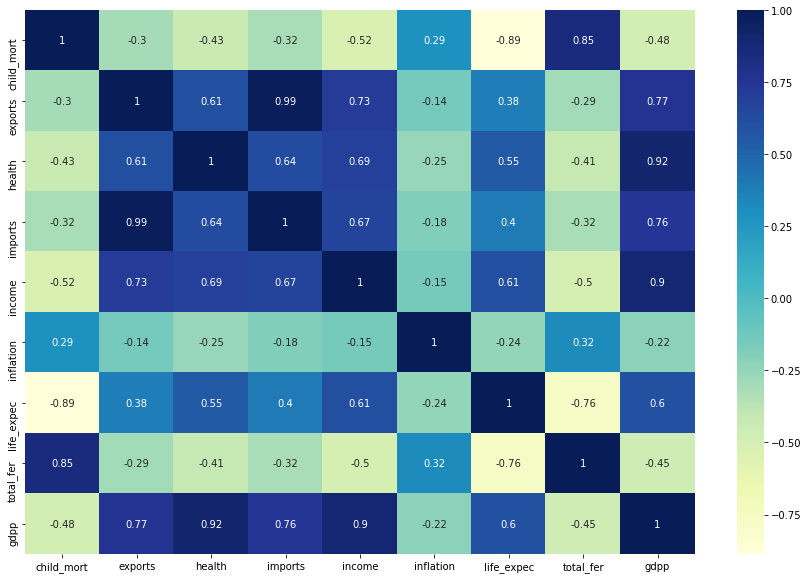

In [12]:
# inspecting correlation between variables 

plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),cmap='YlGnBu',annot=True)
plt.show()

We observe that `gdpp` is highly correlated with `income`,`imports`,`exports`,`health` and `life expectancy`;   
`income` is highly correlated with `gdpp`,`imports`,`exports` and `health`;   
`child mortality` is highly correlated with `total_fer` and is **negatively correlated** with `life expectancy`,`income`,`gdpp` and `health`.

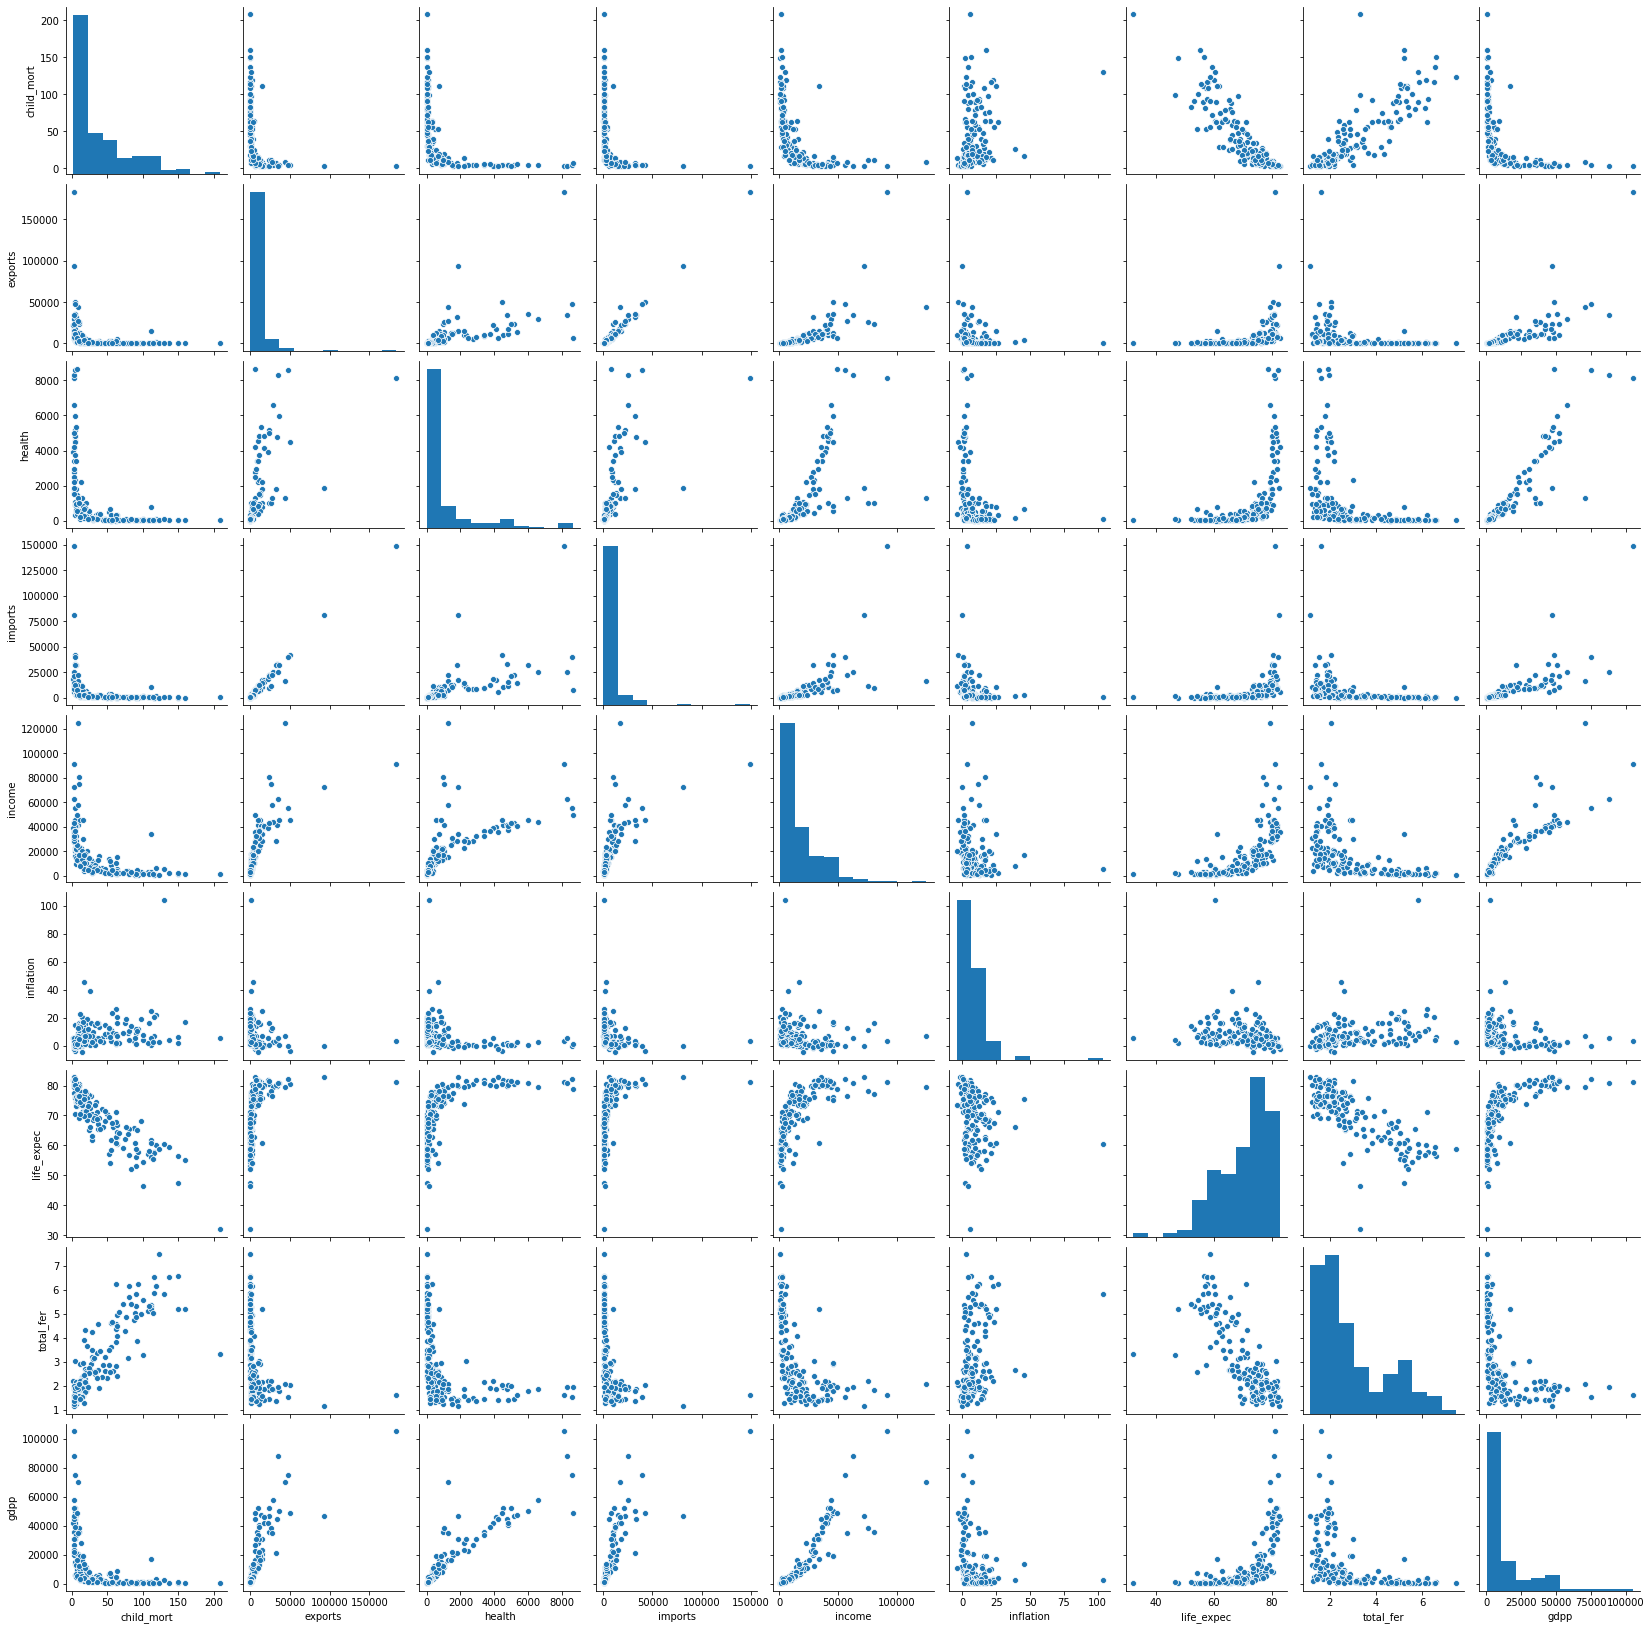

In [13]:
# inspecting relation between all variables

sns.pairplot(data)
plt.show()

#### Step 2.2.1 : Performing Univariate Analysis

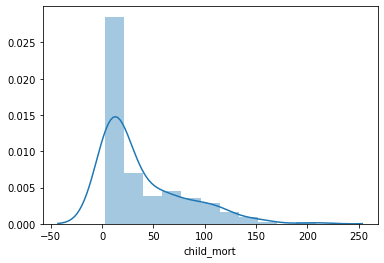

In [14]:
# Inspecting Child Mortality 

sns.distplot(data['child_mort'])
plt.show()

Majority of the countries have a `child mortality rate` of approx. **within 30**, and as the `child mortality` **increases** the **rate decreases**.<br> 

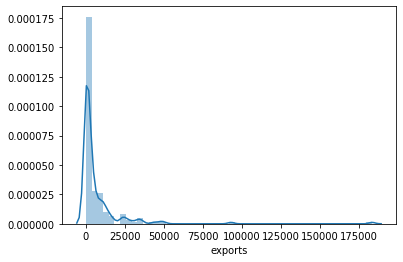

In [15]:
# inspecting Exports 

sns.distplot(data['exports'])
plt.show()

We observe that a very **few countries** have a **high** `export` value and a few have **nearing zero** or **equal to zero**.

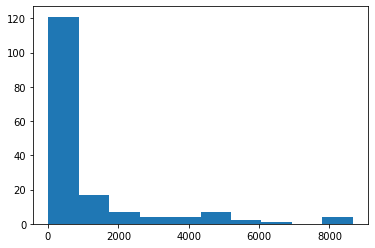

In [16]:
# inspecting Health 

plt.hist(data['health'])
plt.show()

**Majority** of the countries have a **very low** `per capita spending` on `health` and a very **few** have **high**.

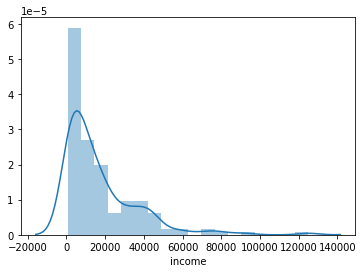

In [17]:
# inspecting Income 

sns.distplot(data['income'])
plt.show()

The graph displays a very typical income situation, **majority** having **low or average income** and a **few** having **high income**.

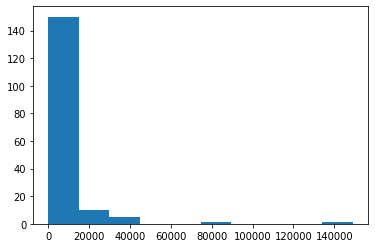

In [18]:
# inspecting Imports 

plt.hist(data['imports'])
plt.show()

A **few countries** having **high** `imports per capita` indicating them to be **reliant** on other countries for goods and services and **others to be self sufficient to certain degree**.

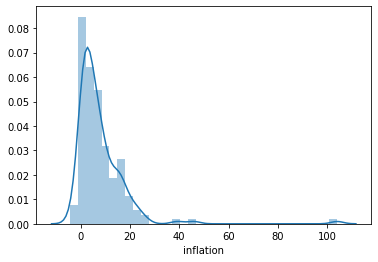

In [19]:
# inspecting Inflation

sns.distplot(data['inflation'])
plt.show()

The graph shows the characteristics of **normal distribution** to an extent indicating a **steady annual growth rate in gdp** for **most** of the countries and a few having **low growth rate** and a **few** having **high growth rate**.

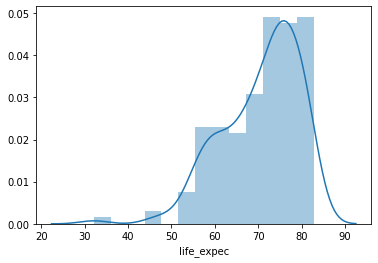

In [20]:
# inspecting Life_expectancy

sns.distplot(data['life_expec'])
plt.show()

`Life Expectancy` of **70-80** is seen in most of the countries. 

#### Step 2.2.2 : Bivariate Analysis

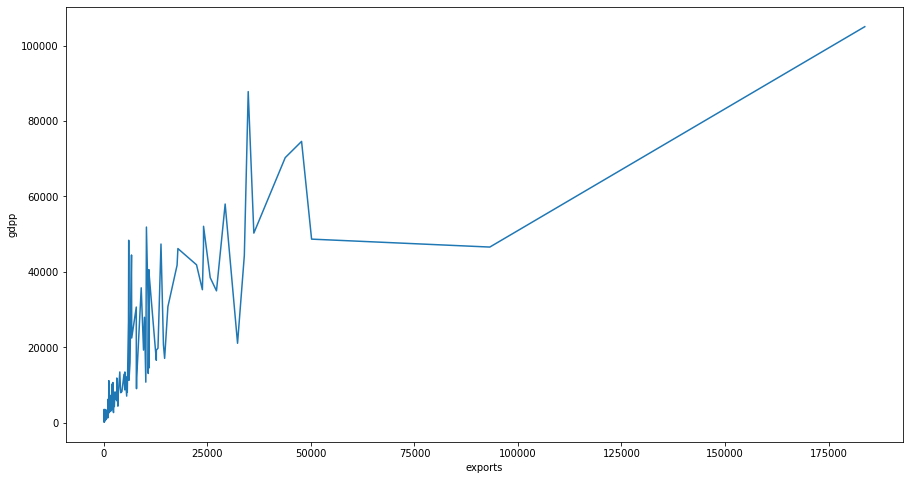

In [21]:
# Analysing GDPP wrt Exports

plt.figure(figsize=(15,8))
sns.lineplot(x=data['exports'],y=data['gdpp'])
plt.show()

We observe that the realtion between `gddp` and `exports` is **linearly positive** for a **few countries** and **negitive** for others. <br>
But a general positive trend is observed.<br>

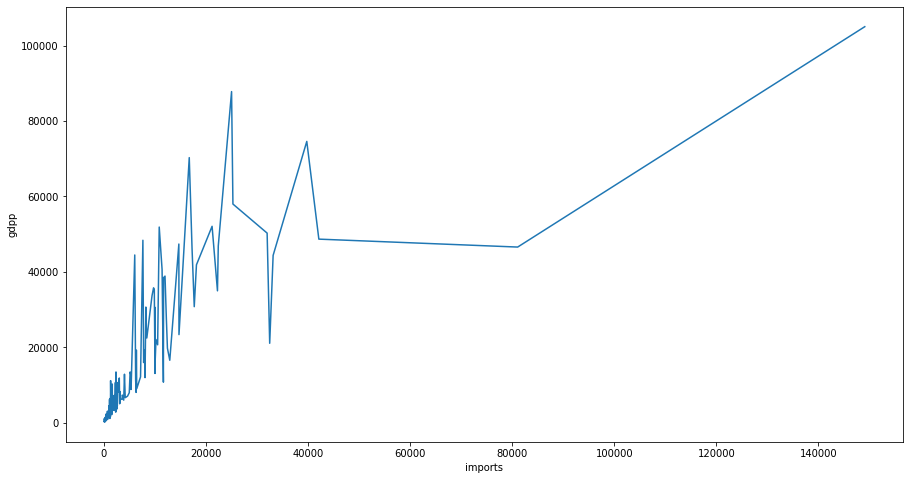

In [22]:
# Analysing GDPP wrt Imports

plt.figure(figsize=(15,8))
sns.lineplot(x='imports',y='gdpp',data=data)
plt.show()

A pattern similar to `GDPP vs Exports` is observed.  
We can thus base our estimation that with the **growth** in the country's `GDP`, `Imports` and `Exports` also **increase**.

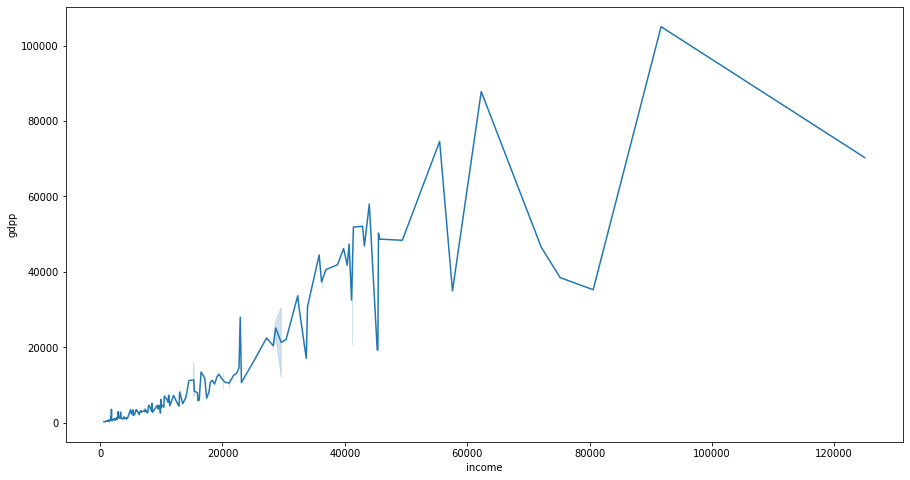

In [23]:
# Analysing GDPP wrt Income

plt.figure(figsize=(15,8))
sns.lineplot(x='income',y='gdpp',data=data)
plt.show()

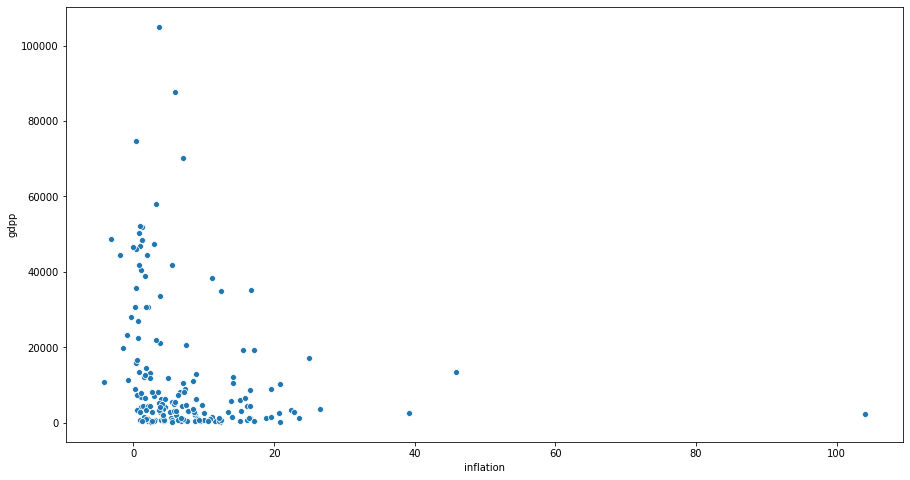

In [24]:
# Analysing GDPP wrt Inflation

plt.figure(figsize=(15,8))
sns.scatterplot(x='inflation',y='gdpp',data=data)
plt.show()

The `Inflaton` rate for majority of the countries is **between 0 and 20** inspite of increase in the `GDPP`.

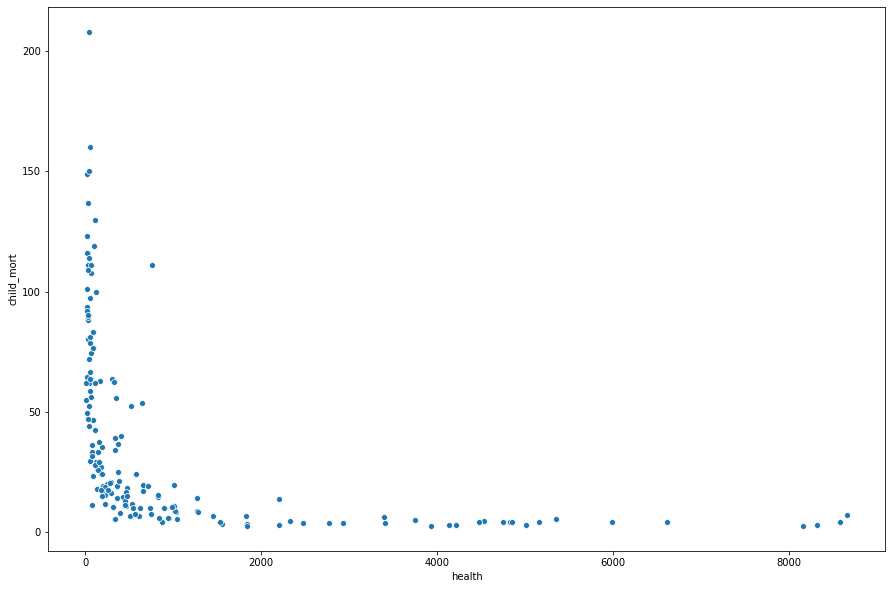

In [25]:
# Analysing Child Mortality wrt Health 

plt.figure(figsize=(15,10))
sns.scatterplot(x='health',y='child_mort',data=data)
plt.show()

Countries having **low spending per capita on health** have higher `child mortality` than those having higher spending on health.

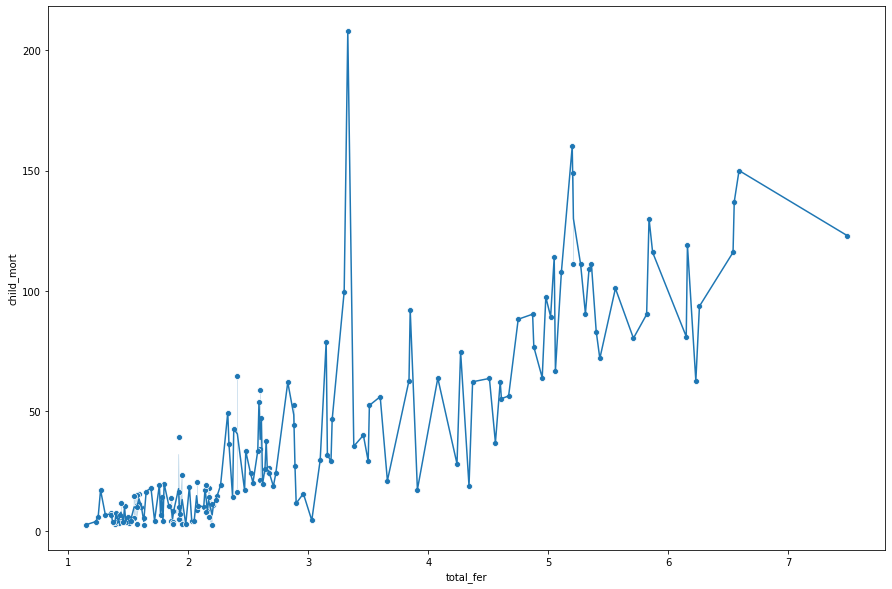

In [26]:
# Analysing Child Mortality wrt Total Fertility

plt.figure(figsize=(15,10))
sns.lineplot(x='total_fer',y='child_mort',data=data)
sns.scatterplot(x='total_fer',y='child_mort',data=data)
plt.show()

Relation between `Child Mortality` and `Total Fertility` is **linearly positive** in nature.  

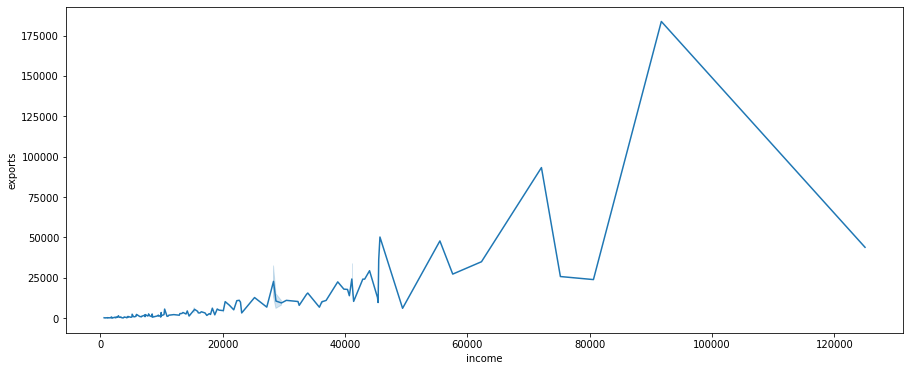

In [27]:
# Analysing Income wrt exports

plt.figure(figsize=(15,6))
sns.lineplot(x='income',y='exports',data=data)
plt.show()

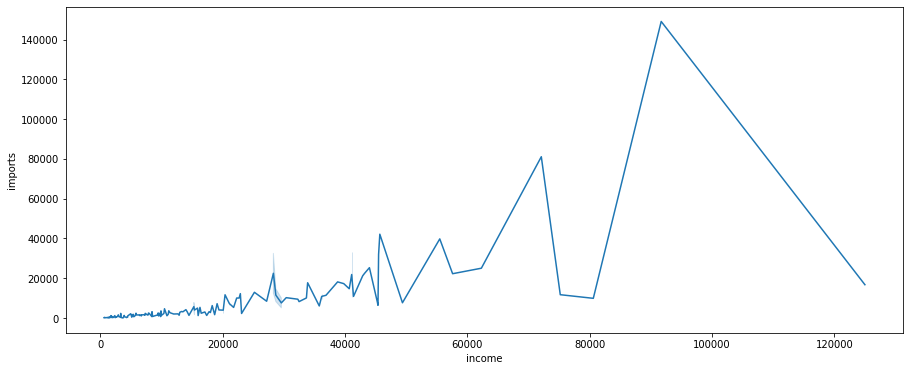

In [28]:
# Analysing Income wrt imports

plt.figure(figsize=(15,6))
sns.lineplot(x='income',y='imports',data=data)
plt.show()

We see that `Imports` and `Exports` have a similar behaviour with **per capita income**. 

## Step 3 : Data Preparation 

### Step 3.1 : Outlier Analysis and Treatment

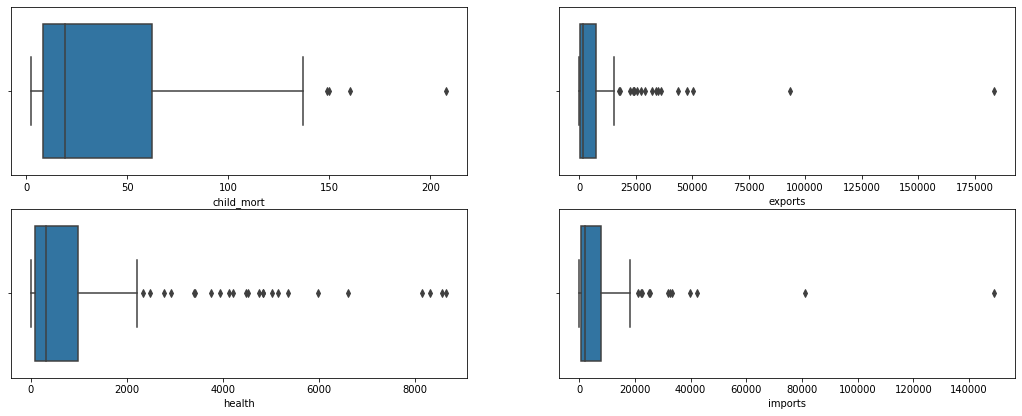

In [29]:
# inspecting outliers for child_mort, exports, health and imports

plt.figure(figsize=(18,18))
cols = data.columns[1:5]
for i in enumerate(cols):
    plt.subplot(5,2,i[0]+1)
    sns.boxplot(data[i[1]])

On analysing the outliers for `child_mort`,`exports`,`health` and `imports` we observe that:     
`child_mort` has a few outliers but these **outliers contribute** in **identifying** the countries **eligible for aid** so we perform **no treatment** on them. 
`exports`,`health` and `imports` have a significant number of **outliers** and their presence can **affect** the **clustering** we perform **hard range capping** on them, so that if they form clusters they could be grouped into one.

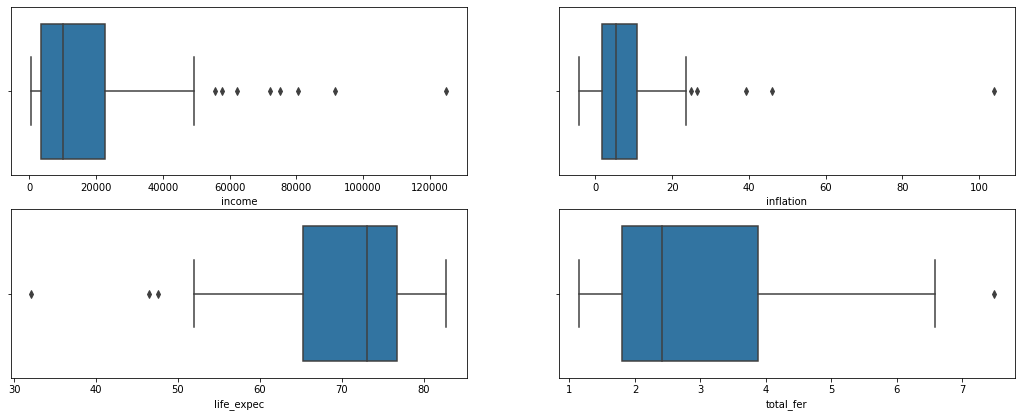

In [30]:
# inspecting outliers for income, inflation, life_expec and total_fer

plt.figure(figsize=(18,18))
cols = data.columns[5:9]
for i in enumerate(cols):
    plt.subplot(5,2,i[0]+1)
    sns.boxplot(data[i[1]])

On analysing the outliers for `income`,`inflation`,`life_expec` and `total_fer` we observe that:    
The presence of outliers in these variables would affect clustering so we perform **hard range capping**.

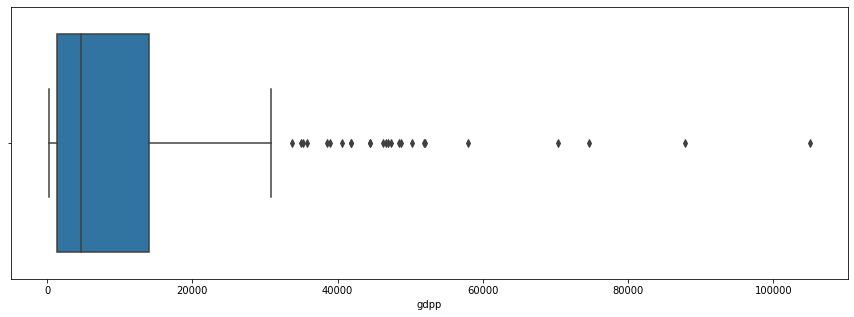

In [31]:
# inspecting outliers for gdpp

plt.figure(figsize=(15,5))
sns.boxplot(data.gdpp)
plt.show()

Similarly for `gdpp`, presence of outliers affects the clustering so we perform **hard range capping**. 

In [32]:
# assigning capping values

exp_q4 = data.exports.quantile(0.75)
hel_q4 = data.health.quantile(0.75)
imp_q4 = data.imports.quantile(0.75)
inc_q4 = data.income.quantile(0.75)
inf_q4 = data.inflation.quantile(0.75)
tot_q4 = data.total_fer.quantile(0.75)
lif_q1 = data.life_expec.quantile(0.25)
gdp_q4 = data.gdpp.quantile(0.75)

In [33]:
# performing capping 

data.exports[data.exports >= exp_q4] = exp_q4
data.health[data.health >= hel_q4] = hel_q4
data.imports[data.imports >= imp_q4] = imp_q4
data.income[data.income >= imp_q4] = inc_q4
data.inflation[data.inflation >= inf_q4] = inf_q4
data.total_fer[data.total_fer >= tot_q4] = tot_q4
data.life_expec[data.life_expec <= lif_q1] = lif_q1
data.gdpp[data.gdpp >= gdp_q4] = gdp_q4

## Step 4 : Clustering 

### Step 4.1 : Hopkins Score Test

In [34]:
# calculating hopkins score

cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [35]:
hopkins(data[cols])

0.9347767425806229

On checking **Hopkins Score** multiple times the data produces the values in the range **90-95**. And thus we can conclude the data will produce clear and good clusters.

### Step 4.2 : Scaling 

In [36]:
# creating an object of StandardScaler 

scaler = StandardScaler()

In [37]:
# scaling variables 

new_data = scaler.fit_transform(data[cols])

In [38]:
# inspecting scaled values

new_data = pd.DataFrame(new_data)
new_data.columns = data.columns[1:]
new_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000
std,1.0030,1.0030,1.0030,1.0030,1.0030,1.0030,1.0030,1.0030,1.0030
min,-0.8871,-1.0574,-1.1255,-1.1041,-1.4559,-2.3814,-1.2158,-1.5539,-1.1964
25%,-0.7466,-0.9028,-0.9522,-0.8896,-1.1729,-0.9053,-1.2158,-0.8620,-0.9916
50%,-0.4718,-0.4416,-0.3105,-0.4182,0.8314,-0.0275,0.1201,-0.2022,-0.3712
75%,0.5927,1.3700,1.3947,1.4726,0.8314,1.2684,0.7538,1.3588,1.3269
max,4.2213,1.4654,1.4167,1.4848,0.8314,1.2867,1.7814,1.3749,1.3781


### Step 4.3 : Finding Number of Clusters

#### Step 4.3.1 : Silhouette Score 

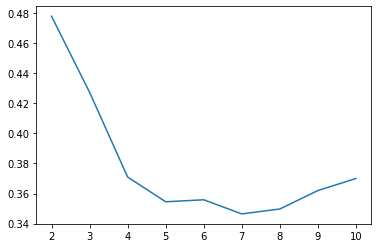

In [39]:
# calculating silhoulette score

ss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(new_data)
    ss.append([k, silhouette_score(new_data, kmeans.labels_)])

plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])
plt.show()

In [40]:
# inspecting silhoulette scores

ss

[[2, 0.47772748322600017],
 [3, 0.42720825608765894],
 [4, 0.3709355851863253],
 [5, 0.35450219828010365],
 [6, 0.3558362986405814],
 [7, 0.3464421690925718],
 [8, 0.34970305854996475],
 [9, 0.3619643065375872],
 [10, 0.36996445766793756]]

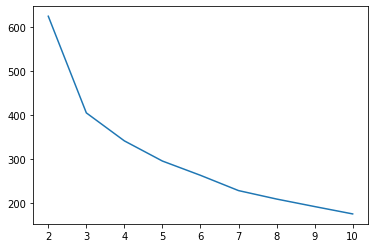

In [41]:
# inspecting elbow curve

ssd = []
for k in range(2, 11):
    kmean = KMeans(n_clusters = k).fit(new_data)
    ssd.append([k, kmean.inertia_])
    
plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])
plt.show()

In [42]:
# inspecting elbow values

ssd

[[2, 624.4847798887267],
 [3, 405.1571143396584],
 [4, 341.59441468786434],
 [5, 295.81293896231966],
 [6, 263.42814420369194],
 [7, 228.77621783949164],
 [8, 209.60073844419313],
 [9, 192.5468491505138],
 [10, 175.83044600836246]]

From the inspection of **silhouette scores** and **elbow values** we can consider the **optimal** number of **clusters** to be **3**.

### Step 4.4: Clustering : K - Means

In [43]:
# clustering with K = 3

kmean = KMeans(n_clusters = 3, random_state = 100)
kmean.fit(data[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [44]:
# assigning label values and adding the column to the dataset

label = pd.DataFrame(kmean.labels_, columns = ['cluster_id'])
data.kmean = data.copy()
data.kmean = pd.concat([data.kmean, label ], axis =1)
data = data.kmean

In [45]:
# inspecting dataframe 

data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,65.3000,3.8800,553,1
1,Albania,16.6000,"1,145.2000",267.8950,"1,987.7400",22800,4.4900,76.3000,1.6500,4090,0
2,Algeria,27.3000,"1,712.6400",185.9820,"1,400.4400",22800,10.7500,76.5000,2.8900,4460,0
3,Angola,119.0000,"2,199.1900",100.6050,"1,514.3700",5900,10.7500,65.3000,3.8800,3530,1
4,Antigua and Barbuda,10.3000,"5,551.0000",735.6600,"7,185.8000",22800,1.4400,76.8000,2.1300,12200,2


In [46]:
# inspecting value count of labels

data.cluster_id.value_counts()

1    69
2    53
0    45
Name: cluster_id, dtype: int64

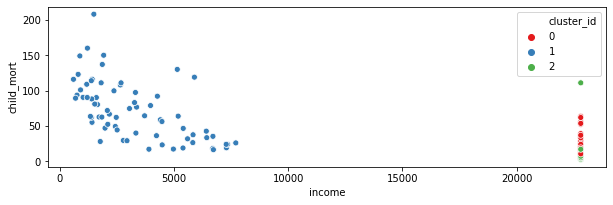

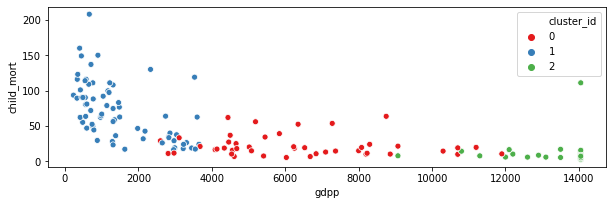

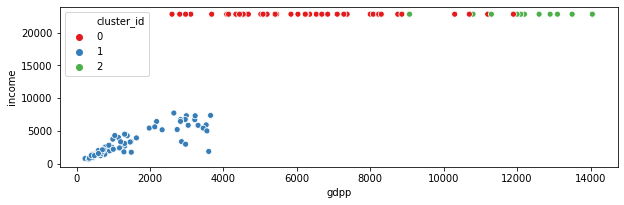

In [47]:
# viewing clusters 

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
sns.scatterplot(x='income',y='child_mort',hue='cluster_id',data=data,palette='Set1')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(3,1,2)
sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_id',data=data,palette='Set1')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(3,1,3)
sns.scatterplot(x='gdpp',y='income',hue='cluster_id',data=data,palette='Set1')
plt.show()

As we can see `cluster 1` is **least performing** cluster and can be considered as the **primary cluster** for **recieving aid**.

#### Cluster Profiling

In [48]:
# analysing mean values of different clusters

data.groupby('cluster_id').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,22.2156,"2,376.9613",421.9036,"2,515.0858","22,800.0000",6.2855,73.2911,2.2393,"6,336.2222"
1,71.5087,503.9661,90.0888,733.1368,"3,277.2899",6.8514,67.1913,3.4013,"1,488.6087"
2,8.6283,"6,939.6887",909.8082,"7,284.8887","22,800.0000",3.0806,78.4208,1.8581,"13,644.7170"


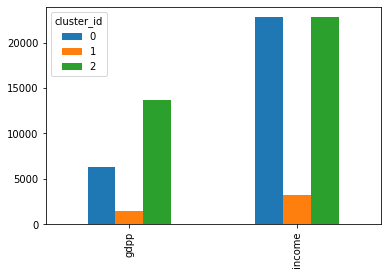

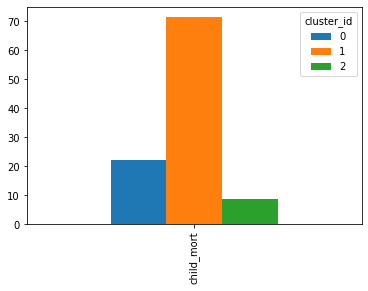

In [49]:
# analysing different measures of clusters

data.pivot_table(values=['income','gdpp'],columns='cluster_id',aggfunc='mean').plot(kind='bar')

data.pivot_table(values='child_mort',columns='cluster_id',aggfunc='mean').plot(kind='bar')

From above analysis we can see that `cluster 1` has the **poor performance** in all the three criteria and thus we select `cluster 1` as the cluster **eligible for aid** and we can also **confirm** that **selection** of **3 clusters** proves **effective** in the current scenario. 

In [50]:
# filtering data with cluster_id as 1

data[data.cluster_id==1]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,65.3000,3.8800,553,1
3,Angola,119.0000,"2,199.1900",100.6050,"1,514.3700",5900,10.7500,65.3000,3.8800,3530,1
6,Armenia,18.1000,669.7600,141.6800,"1,458.6600",6700,7.7700,73.3000,1.6900,3220,1
12,Bangladesh,49.4000,121.2800,26.6816,165.2440,2440,7.1400,70.4000,2.3300,758,1
17,Benin,111.0000,180.4040,31.0780,281.9760,1820,0.8850,65.3000,3.8800,758,1
...,...,...,...,...,...,...,...,...,...,...,...
161,Uzbekistan,36.3000,437.4600,80.1780,393.3000,4240,10.7500,68.8000,2.3400,1380,1
162,Vanuatu,29.2000,"1,384.0200",155.9250,"1,565.1900",2950,2.6200,65.3000,3.5000,2970,1
164,Vietnam,23.3000,943.2000,89.6040,"1,050.6200",4490,10.7500,73.1000,1.9500,1310,1
165,Yemen,56.3000,393.0000,67.8580,450.6400,4480,10.7500,67.5000,3.8800,1310,1


In [51]:
# selecting top 5 countries in dire need of aid

data[data.cluster_id==1].sort_values(by=['gdpp','child_mort','income'],ascending=[True,False,True]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
26,Burundi,93.6000,20.6052,26.7960,90.5520,764,10.7500,65.3000,3.8800,231,1
88,Liberia,89.3000,62.4570,38.5860,302.8020,700,5.4700,65.3000,3.8800,327,1
37,"Congo, Dem. Rep.",116.0000,137.2740,26.4194,165.6640,609,10.7500,65.3000,3.8800,334,1
112,Niger,123.0000,77.2560,17.9568,170.8680,814,2.5500,65.3000,3.8800,348,1
132,Sierra Leone,160.0000,67.0320,52.2690,137.6550,1220,10.7500,65.3000,3.8800,399,1


### Step 4.5 : Clustering - Hierarchical 

#### Step 4.5.1 : Single Linkage 

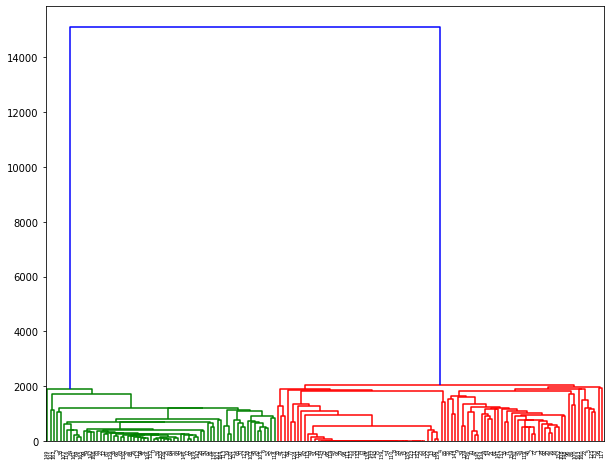

In [52]:
# performing single linkage clustering

plt.figure(figsize=(10,8))
merging = linkage(data[cols], method="single", metric='euclidean')
dendrogram(merging)
plt.show()

As we are **not clearly** able to **identify clusters** from the **dendogram** obtained from **single linkage clustering** we perform **complete linkage clustering**.

#### Step 4.5.2 : Complete Linkage

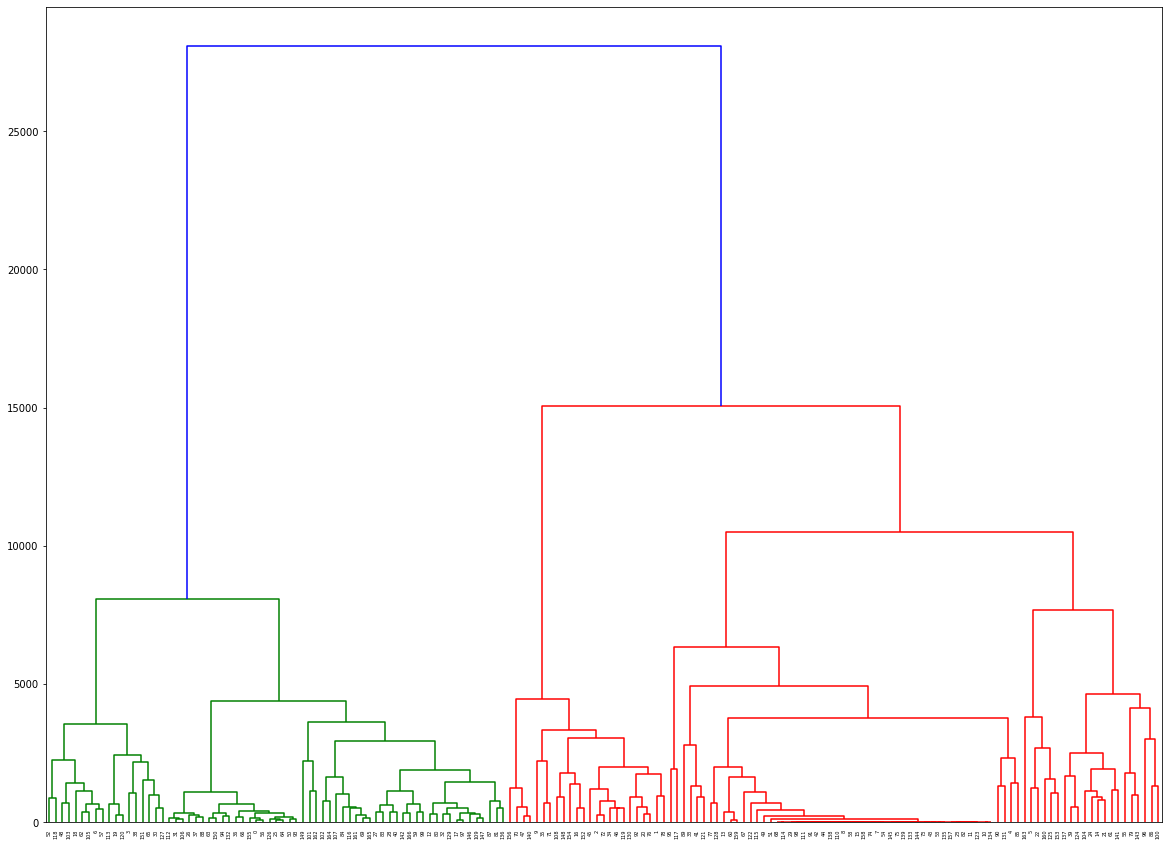

In [53]:
# performing complete linkage clustering

plt.figure(figsize=(20,15))
merging = linkage(data[cols], method="complete", metric='euclidean')
dendrogram(merging)
plt.show()

In [54]:
# performing analysis with 3 clusters

cluster_labels = cut_tree(merging,n_clusters=3).reshape(-1,)

# inspecting labels

cluster_labels

array([0, 1, 1, 0, 2, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 2,
       2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 2,
       2, 1, 1, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0,
       0, 2, 2, 2, 1, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 1, 2,
       1, 0, 1, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0])

In [55]:
# assigning cluster labels

data['cluster_labels'] = cluster_labels

# inspecting dataframe

data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,65.3000,3.8800,553,1,0
1,Albania,16.6000,"1,145.2000",267.8950,"1,987.7400",22800,4.4900,76.3000,1.6500,4090,0,1
2,Algeria,27.3000,"1,712.6400",185.9820,"1,400.4400",22800,10.7500,76.5000,2.8900,4460,0,1
3,Angola,119.0000,"2,199.1900",100.6050,"1,514.3700",5900,10.7500,65.3000,3.8800,3530,1,0
4,Antigua and Barbuda,10.3000,"5,551.0000",735.6600,"7,185.8000",22800,1.4400,76.8000,2.1300,12200,2,2


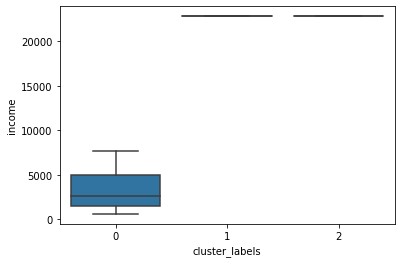

In [56]:
# inspecting income for cluster lables

sns.boxplot(x='cluster_labels',y='income',data=data)
plt.show()

We see that `cluster 0` has the **lowest income** among the clusters.

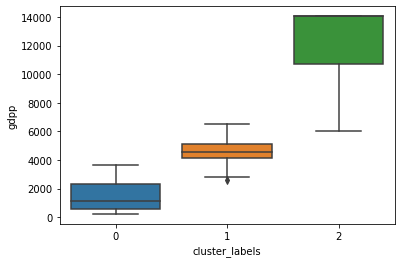

In [57]:
# inspecting gdpp for cluster labels

sns.boxplot(x='cluster_labels',y='gdpp',data=data)
plt.show()

`gdpp` of `cluster 0` is the **lowest** among others.

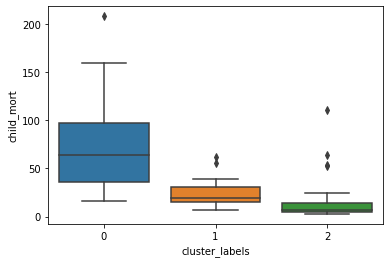

In [58]:
# inspecting child_mort for cluster labels 

sns.boxplot(x='cluster_labels',y='child_mort',data=data)
plt.show()

`child_mort` of `cluster 0` is **highest** among others.
  
And so we can conclude that countries from `cluster 0` are the **most eligible** for aid.

In [59]:
# filtering data with cluster_label 0

data[data.cluster_labels==0]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2000,55.3000,41.9174,248.2970,1610,9.4400,65.3000,3.8800,553,1,0
3,Angola,119.0000,"2,199.1900",100.6050,"1,514.3700",5900,10.7500,65.3000,3.8800,3530,1,0
6,Armenia,18.1000,669.7600,141.6800,"1,458.6600",6700,7.7700,73.3000,1.6900,3220,1,0
12,Bangladesh,49.4000,121.2800,26.6816,165.2440,2440,7.1400,70.4000,2.3300,758,1,0
17,Benin,111.0000,180.4040,31.0780,281.9760,1820,0.8850,65.3000,3.8800,758,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
161,Uzbekistan,36.3000,437.4600,80.1780,393.3000,4240,10.7500,68.8000,2.3400,1380,1,0
162,Vanuatu,29.2000,"1,384.0200",155.9250,"1,565.1900",2950,2.6200,65.3000,3.5000,2970,1,0
164,Vietnam,23.3000,943.2000,89.6040,"1,050.6200",4490,10.7500,73.1000,1.9500,1310,1,0
165,Yemen,56.3000,393.0000,67.8580,450.6400,4480,10.7500,67.5000,3.8800,1310,1,0


In [60]:
# selecting top 5 countries in need of aid

data[data.cluster_labels==0].sort_values(by=['gdpp','child_mort','income'],ascending=[True,False,True]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
26,Burundi,93.6000,20.6052,26.7960,90.5520,764,10.7500,65.3000,3.8800,231,1,0
88,Liberia,89.3000,62.4570,38.5860,302.8020,700,5.4700,65.3000,3.8800,327,1,0
37,"Congo, Dem. Rep.",116.0000,137.2740,26.4194,165.6640,609,10.7500,65.3000,3.8800,334,1,0
112,Niger,123.0000,77.2560,17.9568,170.8680,814,2.5500,65.3000,3.8800,348,1,0
132,Sierra Leone,160.0000,67.0320,52.2690,137.6550,1220,10.7500,65.3000,3.8800,399,1,0


### Step 5: Recommendation

Thus from the above analysis we can conclude that `Burundi`,`Liberia`,`Congo,Dem.Rep.`,`Niger` and `Sierra Leone` are the **5 most under developed countries and are in dire need of aid**.